In [1]:
import pandas as pd
import torch
import json
import os
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import ScalarFormatter
from sklearn.metrics import f1_score,accuracy_score,recall_score
import traceback



import warnings
warnings.filterwarnings('ignore')

In [2]:
from aif360.sklearn import metrics
from sklearn.metrics import confusion_matrix

In [66]:
namedic2 = {}
namedic2['baseline_pred'] = 'LR'
namedic2['randomforest_pred'] = 'RF'
namedic2['adv_rew_pred'] = 'SREW'
namedic2['lfr_pred'] = 'LFR'
namedic2['adv_deb_pred'] = 'ADDEB'
namedic2['egr_pred'] = 'EGR'
namedic2['gsr_pred'] = 'GSR'
namedic2['caleq_pred'] = 'CALEQ'
namedic2['rocv_pred'] = 'ROC'
namedic2['DRO_pred'] = 'MDRO'
namedic2['Softweights_pred'] = 'SOFT'
namedic2['private_pred'] = 'PRIV'
namedic2['ARL_pred'] = 'ARL'
namedic2['OG_DRO_pred'] = 'DRO'
def algnames(name):
    return namedic2[name]

In [67]:
# Try with Adult First

In [68]:
paths  = ['data/datasets/publiccov_ca/', 'data/datasets/employment_ca/', 'data/datasets/law_school/', 'data/datasets/diabetes/']

dnames = {'publiccov_ca': 'Public Coverage',
          'employment_ca': 'Employment',
          'law_school': 'Law School Admissions',
          'diabetes': 'Diabetes'
         }
cnames = [['AGEP', 'SCHL', 'MAR', 'SEX', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'PINCP', 'ESR', 'FER', 'RAC1P',
       'PUBCOV'],
          ['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR'],
          ['zfygpa', 'zgpa', 'DOB_yr', 'weighted_lsat_ugpa', 'cluster_tier',
       'family_income', 'lsat', 'ugpa', 'isPartTime', 'sex', 'race',
       'pass_bar'],
          ['race', 'sex', 'age', 'admissiontypeid', 'dischargedispositionid',
       'admissionsourceid', 'timeinhospital', 'numlabprocedures',
       'numprocedures', 'nummedications', 'numberoutpatient',
       'numberemergency', 'numberinpatient', 'diag1', 'diag2', 'diag3',
       'numberdiagnoses', 'maxgluserum', 'A1Cresult', 'metformin',
       'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed', 'readmitted']
]

In [69]:
list1 = ['baseline_pred','randomforest_pred']
    
list2 = ['adv_rew_pred',
             'adv_deb_pred',
             'lfr_pred',
             'caleq_pred',
             'rocv_pred',
             'egr_pred',
             'gsr_pred']
    
list3 = ['Softweights_pred','private_pred', 'DRO_pred']
    
list4 = ['ARL_pred', 'OG_DRO_pred']

In [70]:
def getresultsdic(path,cols):
    
    results_df = pd.read_csv(path+'test.csv',header=None)
    results_df.columns = cols
    results_df['ground_truth'] = pd.Categorical(results_df[cols[-1]]).codes
    results_df.drop(cols[-1],axis=1,inplace=True)
    
    results = {}
    ground_truth = results_df['ground_truth']
    patt = ""
    
    if 'sex' in results_df.columns:
        patt = 'sex'
    else:
        patt = 'SEX'
    ground_truth.index = results_df[patt]
    
    for file in os.listdir(path+'preds/'):
        # check only text files
        preds = None
        cname = file.split('.')[0]
        alg = cname.split('_pred')[0]+'_pred'

        if file.endswith('.json'):
            f = open(path+'preds/'+file)
            items = json.load(f)
            f.close()
            preds=items
        if file.endswith('.pt') and 'model' not in file:
            items = torch.load(path+'preds/'+file)
            cname = file.split('.')[0]
            preds=[int(i) for i in items.flatten().cpu().numpy()]
            
        
        if alg in list(namedic2.keys()):
            if 'Accuracy' not in results:
                results['Accuracy'] = {}
            out_pred = pd.Series(preds)
            out_pred.index = results_df[patt]
            
            if alg not in results['Accuracy']:
                results['Accuracy'][alg] = []
            results['Accuracy'][alg].append(accuracy_score(list(ground_truth), list(out_pred)))

            if 'Equal Odds Difference' not in results:
                results['Equal Odds Difference'] = {}
                
            if alg not in results['Equal Odds Difference']:
                results['Equal Odds Difference'][alg] = []
            results['Equal Odds Difference'][alg].append(metrics.average_odds_difference(ground_truth,out_pred,prot_attr=patt, priv_group = 'Male', pos_label = 1))

        
    return results


# 2 line plots per metric - synthetic
# histograms for case studies 

def get_df(results):

    DF_list = []

    for metric in results:
        algset = {}
        for alg in results[metric]:
            for val in results[metric][alg]:
                entry = {}
                entry['metric'] = metric
                entry['algorithm'] = algnames(alg.split('_pred')[0]+'_pred')
                entry['value'] = val
                
                if alg in list1:
                    entry['constraints'] = 'No constraints'
                if alg in list2:
                    entry['constraints'] = 'True protected attributes'
                if alg in list3:
                    entry['constraints'] = 'Noisy protected attributes'
                if alg in list4:
                    entry['constraints'] = 'No protected attributes'

                DF_list.append(entry)

    resultsdf = pd.DataFrame(DF_list)
        
    return resultsdf


In [71]:
def task(path,cols):
    results = getresultsdic(path,cols)
    df_temps = get_df(results)
    df_temps.sort_values(by="algorithm", inplace = True)
    df_temps['dataset'] = dnames[path.split('/')[2]]
    return results,df_temps

In [72]:
dfs = []
for tpath,cols in zip(paths,cnames):
    tempdfs = []
    fracs = [0.1,0.5,0.9]
    versions = list(range(10))
    for frac in fracs:
        for ver in versions:
            path = tpath+'synthetic/gender_flip_labels'+str(frac)+'_version'+str(ver)+'/'
            results,tdf = task(path,cols)
            tdf['frac'] = frac
            tempdfs.append(tdf)
    df = pd.concat(tempdfs)
    dfs.append(df)

In [73]:
sorter = list(namedic2.values())

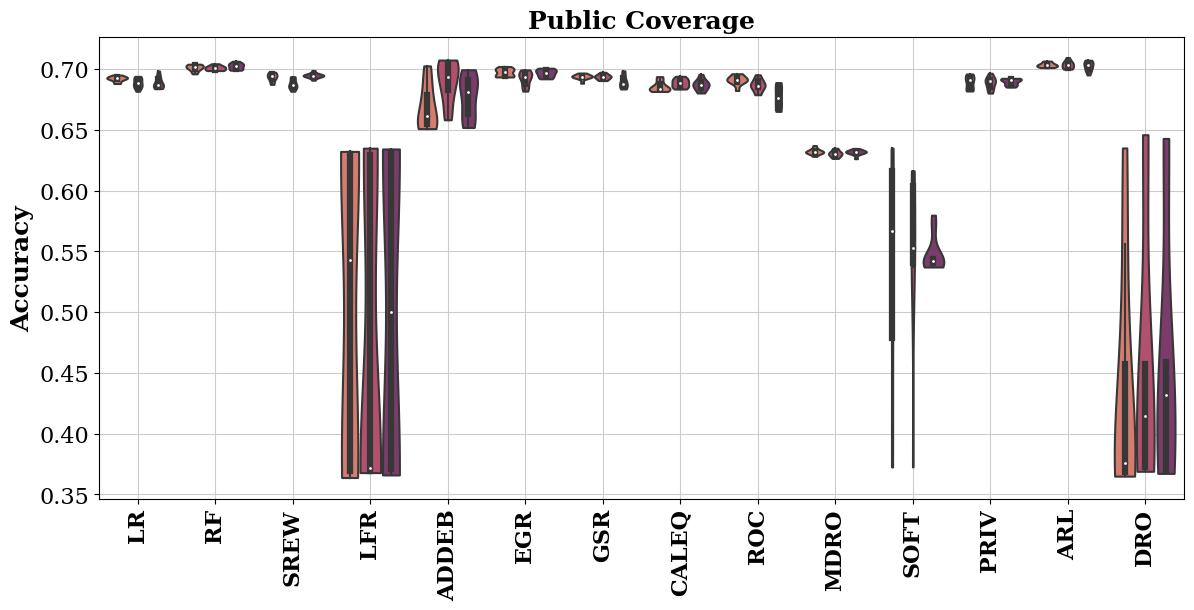

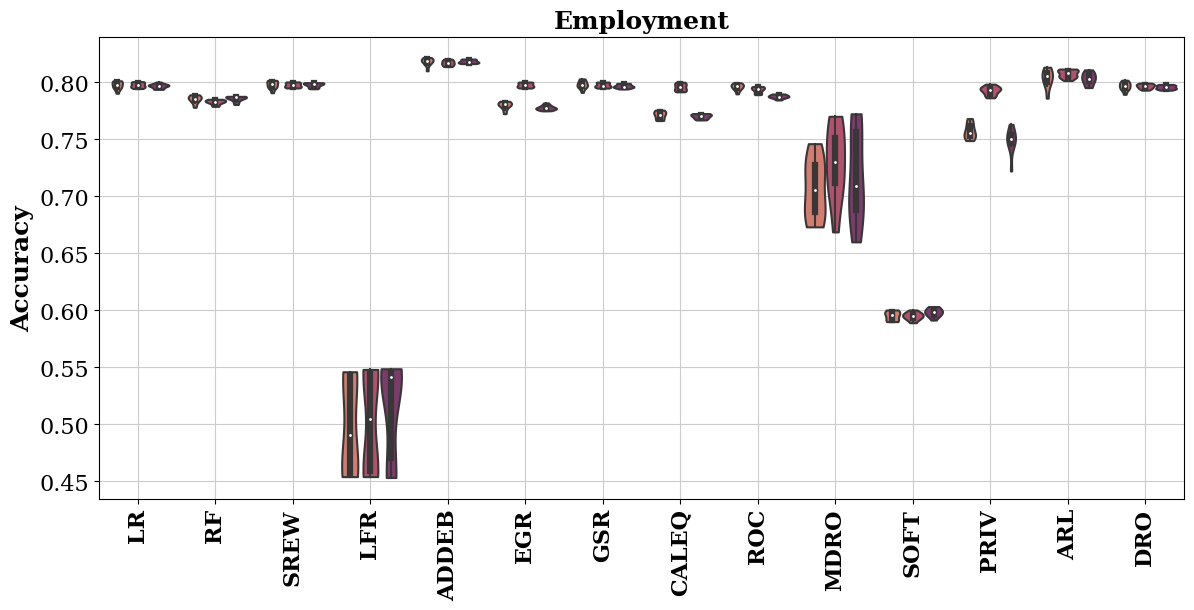

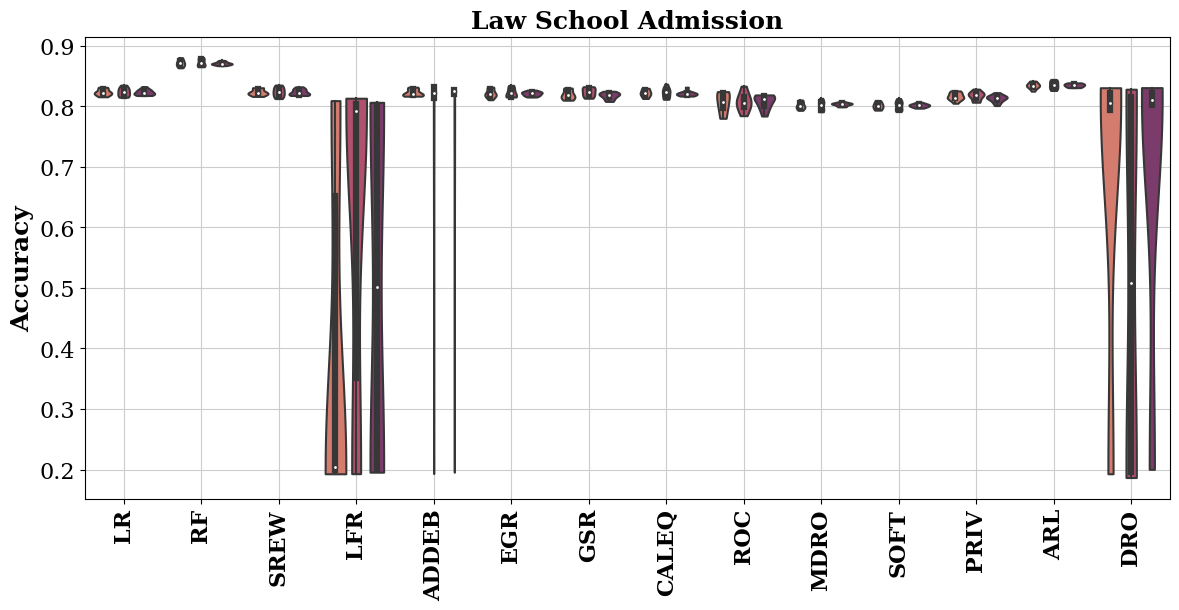

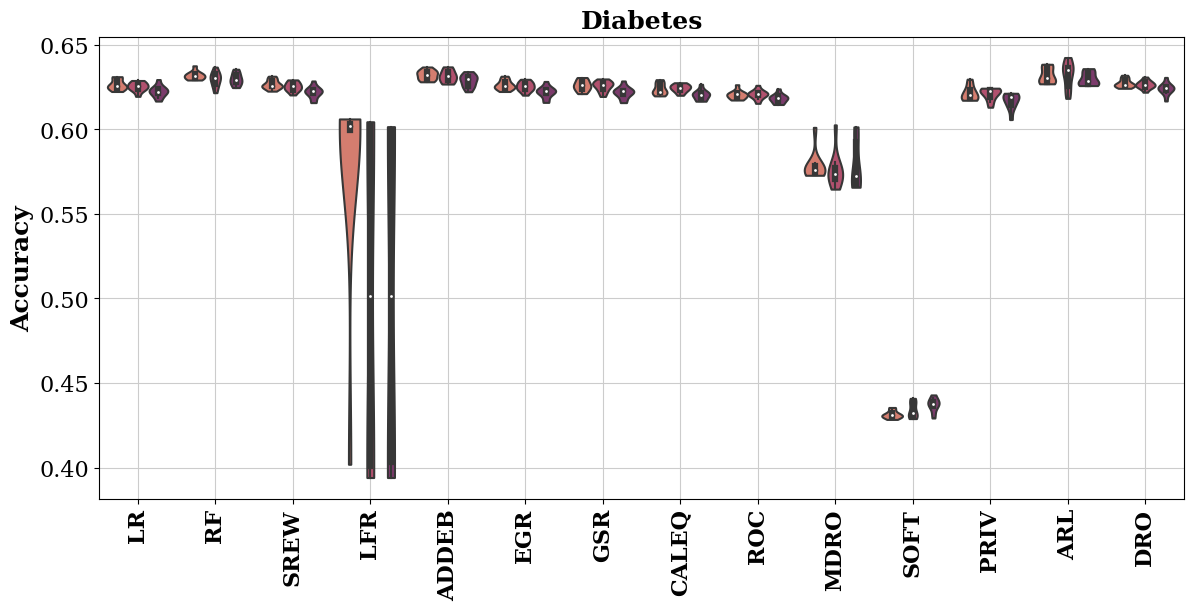

In [77]:
mpl.rcParams['figure.figsize'] = (14, 6)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

import matplotlib.ticker as ticker

hue_order = ['No constraints','True protected attributes', 'Noisy protected attributes', 'No protected attributes']

pp ={'No constraints':'blue','True protected attributes':'orchid', 'Noisy protected attributes':'green', 'No protected attributes':'red'}

titles = ['Public Coverage', 'Employment', 'Law School Admission', 'Diabetes']

alphs = ['(a)', '(b)', '(c)', '(d)']
# alphs2 = ['(e)', '(f)', '(g)', '(h)']


minacc = -0.1
maxacc = 0.8



for tdf,title,alph in zip(dfs,titles,alphs):
    df = tdf[tdf['metric']=='Accuracy']
    
    ax = sns.violinplot(data=df, x="algorithm", y="value", hue='frac', order = sorter, cut = 0, palette = 'flare')#, hue="constraints", hue_order = hue_order, 
#                         palette = pp)
    plt.title(title,fontsize=18,weight='bold')
#     plt.xlabel(alph,fontsize=18,fontweight='bold')
    plt.xlabel(None)
    plt.ylabel('Accuracy',fontsize=18,fontweight='bold')

#         ax.tick_params(axis='x',labelsize=14)
#         ax.set_xticklabels(sorter)
    plt.xticks(rotation = 90, weight='bold')
    plt.yticks(ticks=None, labels=None)


    ax.xaxis.grid(True,which='both')
    ax.yaxis.grid(True,which='both')
    ax.set_axisbelow(True)
#     ax.set_ylim([minacc, maxacc])



    ax.set_facecolor('white')
    ax.tick_params(axis='y', which='both',labelsize=16)
    ax.tick_params(axis='x', which='both',labelsize=16)
    ax.get_legend().remove()

    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#     ax.yaxis.set_ticklabels([])
#     ax.yaxis.set_ticks_position('none')


    plt.savefig('Plots/Stability_Acc_Noise_'+title+'.pdf', pad_inches = 0,bbox_inches = "tight")
    plt.show()

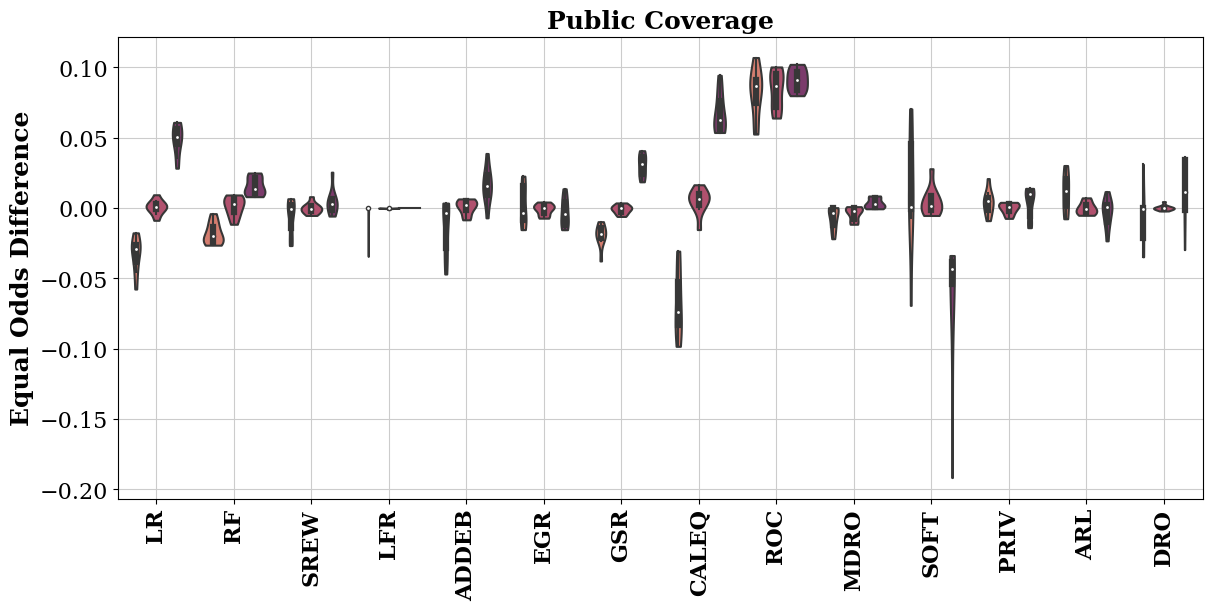

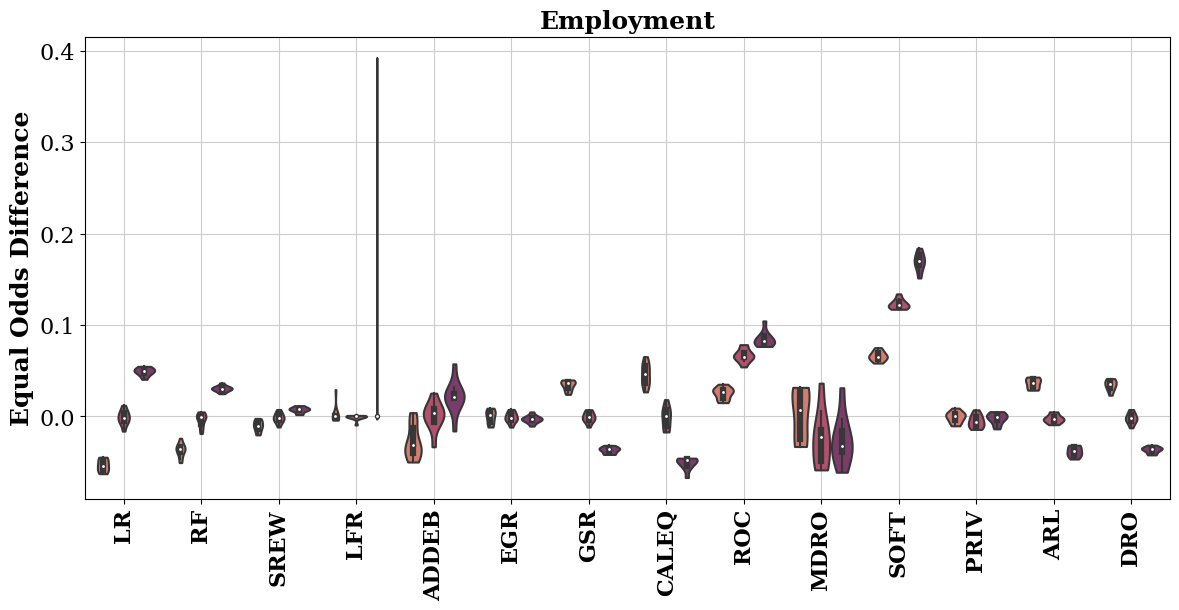

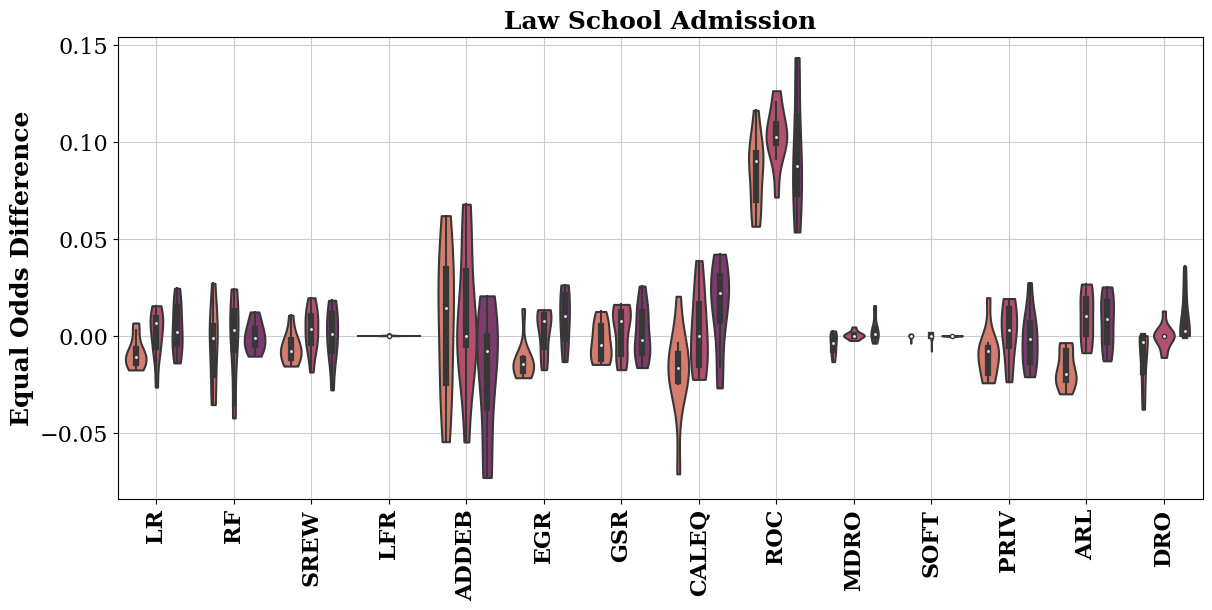

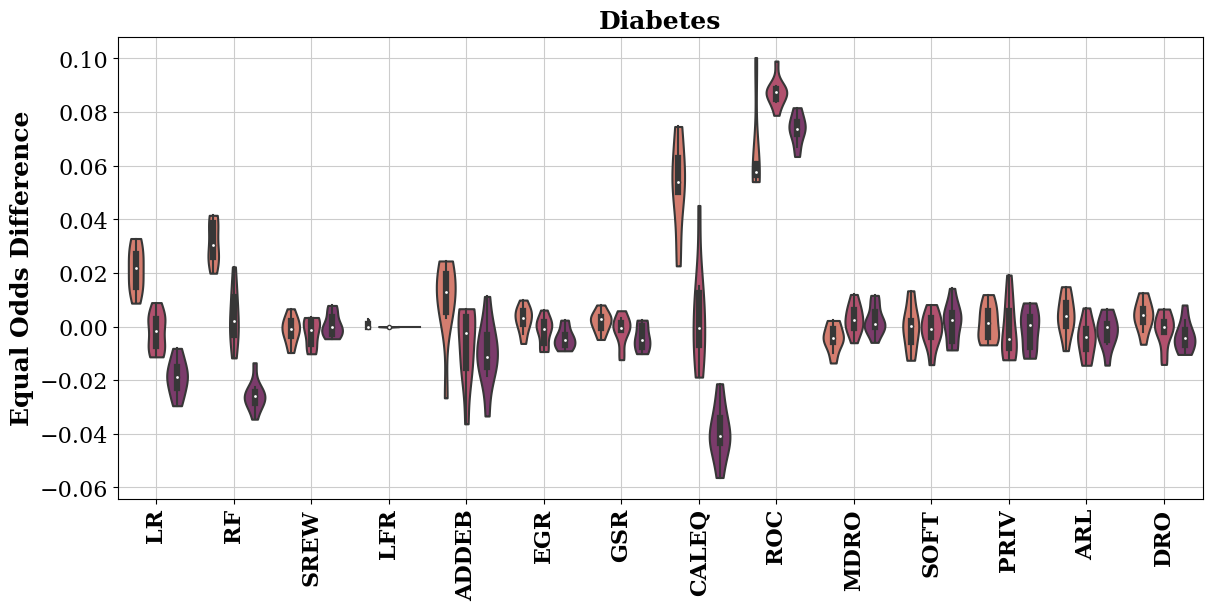

In [78]:
mpl.rcParams['figure.figsize'] = (14, 6)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

import matplotlib.ticker as ticker

hue_order = ['No constraints','True protected attributes', 'Noisy protected attributes', 'No protected attributes']

pp ={'No constraints':'blue','True protected attributes':'orchid', 'Noisy protected attributes':'green', 'No protected attributes':'red'}

# colors = ['blue','blue','orchid','orchid','orchid','orchid','orchid','orchid','orchid','green', 'green','green','red','red']

titles = ['Public Coverage', 'Employment', 'Law School Admission', 'Diabetes']

alphs = ['(a)', '(b)', '(c)', '(d)']
# alphs2 = ['(e)', '(f)', '(g)', '(h)']



for tdf,title,alph in zip(dfs,titles,alphs):
    df = tdf[tdf['metric']=='Equal Odds Difference']
    
    ax = sns.violinplot(data=df, x="algorithm", y="value", hue='frac', order = sorter, cut = 0, palette = 'flare')#, hue="constraints", hue_order = hue_order, 
#                         palette = pp)
    plt.title(title,fontsize=18,weight='bold')
    plt.xlabel(None)
#     plt.xlabel(alph,fontsize=18,fontweight='bold')
#     plt.ylabel(None)
    plt.ylabel('Equal Odds Difference',fontsize=18,fontweight='bold')

#         ax.tick_params(axis='x',labelsize=14)
#         ax.set_xticklabels(sorter)
    plt.xticks(rotation = 90, weight='bold')
    plt.yticks(ticks=None, labels=None)


    ax.xaxis.grid(True,which='both')
    ax.yaxis.grid(True,which='both')
    ax.set_axisbelow(True)
#     ax.set_ylim([minacc, maxacc])



    ax.set_facecolor('white')
    ax.tick_params(axis='y', which='both',labelsize=16)
    ax.tick_params(axis='x', which='both',labelsize=16)
    ax.get_legend().remove()

    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#     ax.yaxis.set_ticklabels([])
#     ax.yaxis.set_ticks_position('none')


    plt.savefig('Plots/Stability_EOD_Noise_'+title+'.pdf', pad_inches = 0,bbox_inches = "tight")
    plt.show()

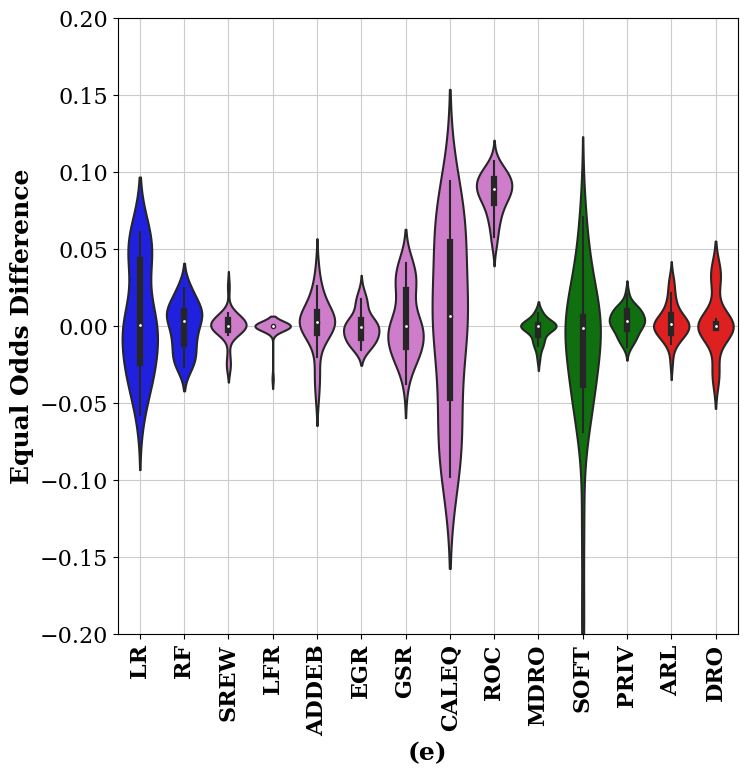

In [76]:
mpl.rcParams['figure.figsize'] = (8, 8)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

import matplotlib.ticker as ticker

hue_order = ['No constraints','True protected attributes', 'Noisy protected attributes', 'No protected attributes']

pp ={'No constraints':'blue','True protected attributes':'orchid', 'Noisy protected attributes':'green', 'No protected attributes':'red'}

titles = ['Public Coverage', 'Employment', 'Law School Admission', 'Diabetes']

alphs = ['(a)', '(b)', '(c)', '(d)']
alphs2 = ['(e)', '(f)', '(g)', '(h)']


minacc = -0.2
maxacc = 0.2



for tdf,title,alph in zip(dfs[:1],titles[:1],alphs2[:1]):
    df = tdf[tdf['metric']=='Equal Odds Difference']
    
    ax = sns.violinplot(data=df, x="algorithm", y="value", dodge=False, order = sorter,hue="constraints", hue_order = hue_order, 
                        palette = pp)
#     plt.title(title,fontsize=18,weight='bold')
#         plt.legend(loc=(1.05, 0))
    plt.xlabel(alph,fontsize=18,fontweight='bold')
#     plt.ylabel(None)
    plt.ylabel('Equal Odds Difference',fontsize=18,fontweight='bold')

#         ax.tick_params(axis='x',labelsize=14)
#         ax.set_xticklabels(sorter)
    plt.xticks(rotation = 90, weight='bold')
    plt.yticks(ticks=None, labels=None)


    ax.xaxis.grid(True,which='both')
    ax.yaxis.grid(True,which='both')
    ax.set_axisbelow(True)
    
    ax.set_ylim([minacc, maxacc])




    ax.set_facecolor('white')
    ax.tick_params(axis='y', which='both',labelsize=16)
    ax.tick_params(axis='x', which='both',labelsize=16)
    ax.get_legend().remove()

#     plt.gca().yaxis.set_major_formatter(ScalarFormatter())
#     ax.yaxis.set_ticklabels([])
#     ax.yaxis.set_ticks_position('none')


    plt.savefig('Plots/Stability_EOD_'+title+'.pdf', pad_inches = 0,bbox_inches = "tight")
    plt.show()

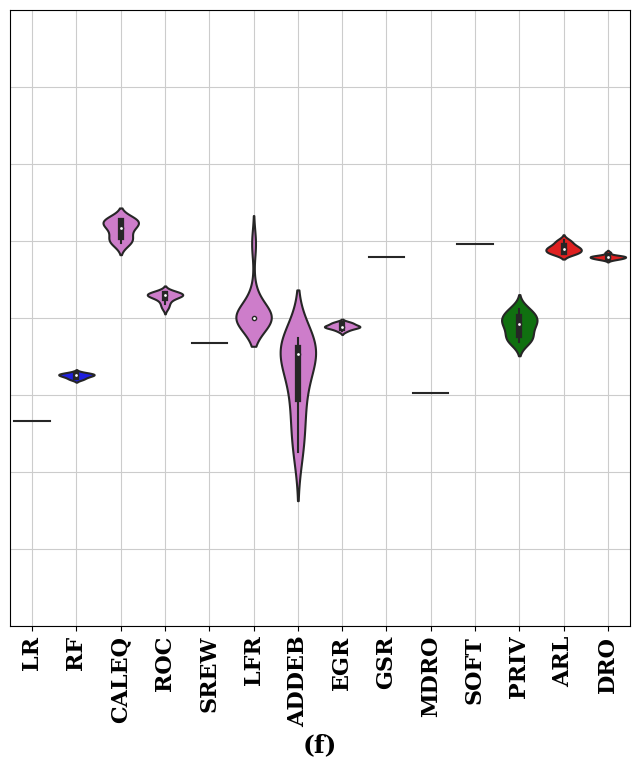

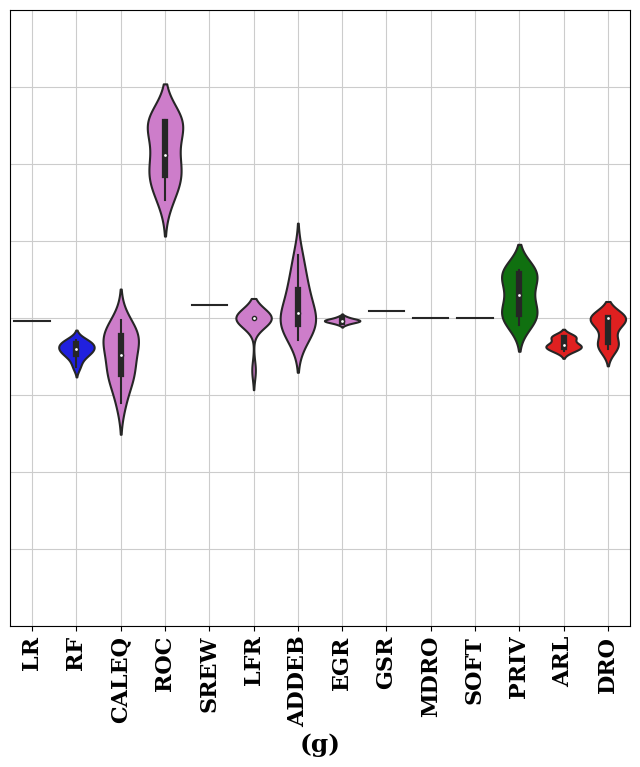

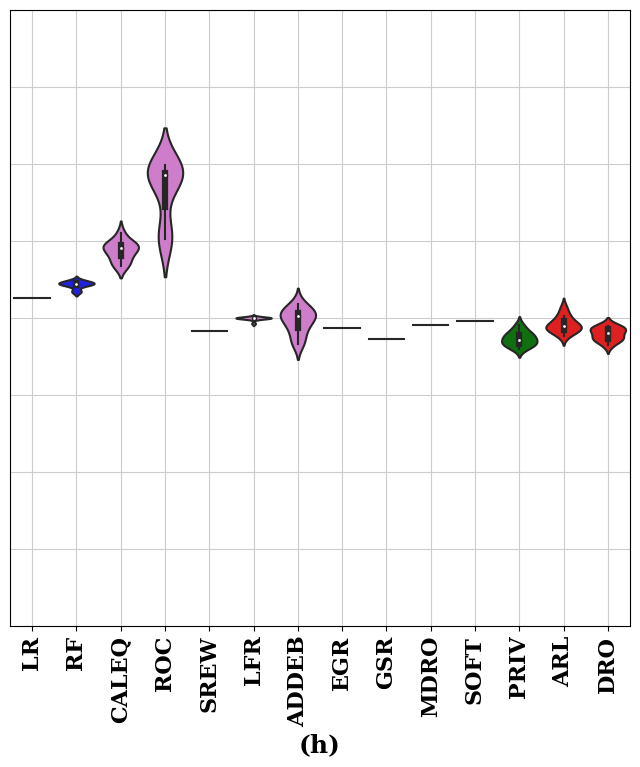

In [77]:
mpl.rcParams['figure.figsize'] = (8, 8)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

import matplotlib.ticker as ticker

hue_order = ['No constraints','True protected attributes', 'Noisy protected attributes', 'No protected attributes']

pp ={'No constraints':'blue','True protected attributes':'orchid', 'Noisy protected attributes':'green', 'No protected attributes':'red'}

titles = ['Public Coverage', 'Employment', 'Law School Admission', 'Diabetes']

alphs = ['(a)', '(b)', '(c)', '(d)']
alphs2 = ['(e)', '(f)', '(g)', '(h)']


minacc = -0.2
maxacc = 0.2



for tdf,title,alph in zip(dfs[1:],titles[1:],alphs2[1:]):
    df = tdf[tdf['metric']=='Equal Odds Difference']
    
    ax = sns.violinplot(data=df, x="algorithm", y="value", dodge=False, order = sorter,hue="constraints", hue_order = hue_order, 
                        palette = pp)
#     plt.title(title,fontsize=18,weight='bold')
#         plt.legend(loc=(1.05, 0))
    plt.xlabel(alph,fontsize=18,fontweight='bold')
    plt.ylabel(None)
#     plt.ylabel('Equal Odds Difference',fontsize=18,fontweight='bold')

#         ax.tick_params(axis='x',labelsize=14)
#         ax.set_xticklabels(sorter)
    plt.xticks(rotation = 90, weight='bold')
    plt.yticks(ticks=None, labels=None)


    ax.xaxis.grid(True,which='both')
    ax.yaxis.grid(True,which='both')
    ax.set_axisbelow(True)
    ax.set_ylim([minacc, maxacc])




    ax.set_facecolor('white')
    ax.tick_params(axis='y', which='both',labelsize=16)
    ax.tick_params(axis='x', which='both',labelsize=16)
    ax.get_legend().remove()

    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks_position('none')


    plt.savefig('Plots/Stability_EOD_'+title+'.pdf', pad_inches = 0,bbox_inches = "tight")
    plt.show()



In [ ]:
fig, axs = plt.subplots(1,4, sharey= True, figsize=(26, 6.1))

# mpl.rcParams['figure.figsize'] = (8, 8)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

hue_order = ['No constraints','True protected attributes', 'Noisy protected attributes', 'No protected attributes']

pp ={'No constraints':'blue','True protected attributes':'purple', 'Noisy protected attributes':'green', 'No protected attributes':'red'}


titles = ['(a) Public Coverage', '(b) Employment', '(c) Law School Admission', '(d) Diabetes']

for ax,tdf,title in zip(axs.flatten(),dfs,titles):
    
    df = tdf[tdf['algorithm']=='Accuracy']
    
    ax = sns.violinplot(ax = ax, data=df, x="algorithm", y="value", dodge=False, order = sorter,
                        hue="constraints", hue_order = hue_order, palette = pp)
    ax.tick_params(axis='x', labelrotation=90)
    ax.xaxis.grid(True,which='both')
    ax.yaxis.grid(True,which='both')
    plt.xticks(visible = True)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.set_title(title, fontsize=15,weight='bold')
#     ax.patch.set_edgecolor('black')  
#     ax.patch.set_linewidth(2)          
    ax.get_legend().remove()
    ax.set(ylabel="")


fig.supylabel('Testy',fontsize=20,weight='bold', x = 0.02)
fig.tight_layout()
# plt.savefig('Stability_Acc.pdf', pad_inches = 0,bbox_inches = "tight")
plt.show()